---

# 1. **Problem definition** 

### **Trees and cars detection**

The objective of this project is to develop a computer vision program that can detect trees and cars from images using Python programming language. The program should be able to take input images in various formats (e.g., JPG, PNG, etc.) and identify regions of the image that contain either a tree or a car.

The program should use a combination of image processing techniques and machine learning algorithms to accurately detect trees and cars and accurately locate them within the image.

The program should be robust enough to handle different lighting conditions, weather conditions, and camera angles. It should also be able to handle images with multiple trees and cars in them, and accurately label each object in the image.

The output of the program should be a list of bounding boxes that contain the detected trees and cars, along with their respective labels. The program should also be able to visualize the detected objects on the input image.

Overall, the goal of this project is to develop a reliable and accurate computer vision program that can detect trees and cars from images for various applications, such as autonomous vehicles, environmental monitoring, and city planning. 

---
# 2. **GitHub repository**

[ITNPAI1-202223_Spring-Trees-and-cars-detection](https://github.com/AzizbekAvazov/ITNPAI1-202223_Spring-Trees-and-cars-detection) 

---
# 3. **Dataset creation**

In this project, the dataset is a collection of images taken by myself on site in two cities, Tashkent and Stirling.

Pascal VOC format was used for annotating each image and storing coordinates of bounding boxes.

---

# 4. **Dataloader**

Here you are required to implement all the code related to pre-processing, cleaning, de-noising and preparing the input images and metadata according to the necessary data structures as input to your pattern recognition module. We recommend using [PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) or [Tensorflow (with Keras)](https://keras.io/getting_started/intro_to_keras_for_engineers/) as a base, but you are free to use any library or platform as long as it is well justified in the final report.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import torch.optim as optim
import time
import torch.nn.functional as F
import os
import xml.etree.ElementTree as ET
import numpy as np
import torchvision.ops.boxes as bops
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import cv2

# path to the training and test images and corresponding label files
city_a_train_dir = "/content/dataset/city_a/train"  
city_a_test_dir = "/content/dataset/city_a/test"

city_b_train_dir = "/content/dataset/city_b/train"
city_b_test_dir = "/content/dataset/city_b/test"

# specify the labels (classes)
# because pre-trained fasterrcnn_resnet50_fpn have been used in this project, it is mandatory to have 'background' label
# which denotes the absence of any object
labels = {"background": 0, "tree": 1, "car": 2}

# it will decide wether the computations will be carried out on CPU or on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Implementation of Custom Dataset Class. This custom dataset class inherits "Dataset" class of PyTorch
# For this custom dataset class to work, the Label files should be in a VOC xml format
# The images and their corresponding label files should be in the same directory

class CustomDataset(Dataset):
    def __init__(self, data_dir, label_dir, transform=None):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.transform = transform
        # load label and image paths from the directory given by 'label_dir'
        self.labels = self.load_labels()

    # returns size of the dataset (number of images (label files) in the dataset)
    def __len__(self):
        return len(self.labels)

    # method to load data located at index 'idx' in the dataset
    def __getitem__(self, idx):
        # 'labels' is initialized in the '__init__' method
        image_path = self.labels[idx]['image_path']
        label_path = self.labels[idx]['label_path']
        
        # read image that is located at index 'idx' in the dataset and then convert it to RGB
        image = Image.open(image_path).convert('RGB')
        # get corresponding information from a label file
        label = self.load_label(label_path)
        
        # apply transofrmations
        image = self.transform(image)

        return image, label

    #  method to load label and image paths from the directory given by 'label_dir'
    def load_labels(self):
        labels = []
        # iterate over each file in the label directory
        for filename in os.listdir(self.label_dir):
            # check if the file is an XML file
            if filename.endswith('.xml'):
                # construct the paths to the image and label files
                label_path = os.path.join(self.label_dir, filename)
                image_path = os.path.join(self.data_dir, os.path.splitext(filename)[0] + '.jpg')
                # add the image and label paths to the labels list as a dictionary
                labels.append({'image_path': image_path, 'label_path': label_path})
        return labels
    
    # method to load required information from VOC format label file
    def load_label(self, label_path):
        # parse the given XML format file using ElementTree library
        tree = ET.parse(label_path)
        # get the roor of the file ('annotations' in this case)
        root = tree.getroot()
        
        # get the value of 'filename' tag in the given XML file
        filename = root.find('filename').text
        
        boxes = []
        names = []
        # find the 'object' tag and parse its child tags
        for obj in root.findall('object'):
            # get value of 'name' tag. 
            # in VOC format label files, the 'name' tag corresponds to 
            # the label (or class) of an object described in the label file
            names.append(labels[obj.find('name').text])
            # 'bndbox' is a tag that stores bounding box coordinates
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        
        # return three informations: 
        # 1) bounding box coordinates ('boxes')
        # 2) labels (or classes) of an object described by each bounding box
        # 3) Name of the file that these informations stored ('filename'). This is needed to monitor which image is being
        # processed during the training so that if there are any corrupt images, we will be able to identify it
        label = {'boxes': torch.tensor(boxes, dtype=torch.float32),
                 'labels': torch.tensor(names, dtype=torch.int64),
                 'filename': filename}
        return label

In [3]:
def getTransforms():
     # ToTensor() is the only transformation used in this project.
    # ToTensor() will transoform input images to tensor and re-scale the values in 0-1 range
    # we don't need to apply any other transformations because all the input images in the dataset have been
    # resized before creating label files.
    # all input images have been resized to have width equal to 416 pixels while height was chosen automatically by
    # the resizing tool to preserve aspect ratio
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    return transform

def getDataset(path):
    # create dataset objects for training and validation
    return CustomDataset(path, path, transform=getTransforms())
    #train_dataset = CustomDataset(train_data_dir, train_voc_label_dir, transform=transform)
    #val_dataset = CustomDataset(val_data_dir, val_voc_label_dir, transform=transform)
    

def getModel():
    # load the pre-trained Faster R-CNN model with a ResNet50 backbone from the torchvision package
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features of the classifier head of the Faster R-CNN model
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the classifier head of the Faster R-CNN model with a new FastRCNNPredictor
    # the new classifier head has the same number of input features as the original one, 
    # but is customized to predict only 3 labels (including the background label)
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=3)

    # move the model object to GPU if available
    model = model.to(device)
    
    return model

def getDataloader(dataset, batchSize):   
    # create PyTorch's 'DataLoader' object. This object will be used during the training to load batches of data
    # currently batch_size 1, because I did not implemented "collate_fn" function which is responsible 
    # for combining individual samples of images and returning them as batches of images and targets to the dataloader
    return torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True)

---

# 5. **Proposed solution** 

In [4]:
def calculateIoU(boxes1, boxes2):
    # boxes1 and boxes2 are both tensors containing N bounding boxes
    # the result of bops.box_iou(boxes1, boxes2) is a N x N matrix
    ious = bops.box_iou(boxes1, boxes2)
    
    # each element in this ('ious') N x N matrix is a IoU value between
    # some bounding box in 'boxes1' and some bounding box in 'boxes2'
    # we need to take the the best IoU value from each row of this matrix, so we will have N IoU values
    max_ious, indices = ious.max(dim=1)
    
    # now we calculate the mean of max_ious to get the IoU value for current prediction and return it
    return max_ious.mean()
    
def train(model, num_of_epochs, dataloader, learningRate):
    train_losses_list = []
    
    # Defining the optimizer
    optimizer = optim.SGD(model.parameters(),lr = learningRate)

    for epoch in range(num_of_epochs):

        model.train()
        
        train_losses = []
        
        for batch, (x, y) in enumerate(dataloader):
            # According to the custom dataset class used in this project
            # x - is an image
            # y - is a dictionary containing 'boxes' and 'labels'. 'boxes' is a list of boxes in a label file
            # 'labels' is a list of labels in a label file
            # x and y hold only information corresponding to a single image sample as the batch size is 1
            boxes = y['boxes']
            labels = y['labels']

            # move 'x', 'boxes' and 'labels' to a GPU if available
            x,boxes,labels = x.to(device),boxes.to(device),labels.to(device)            
            
            # fasterrcnn_resnet50_fpn model during the training accepts two inputs: 
            # 1) batch of images 2) a list of dictionary that has two keys: 'boxes' and 'labels'
            # the following two lines of code are needed to create a 'target' variable which
            # hold all the information in the format that fasterrcnn_resnet50_fpn model accepts
            targets=[{'boxes': boxes, 'labels': labels}]
            targets = [{'boxes': b, 'labels': l} for b, l in zip(targets[0]['boxes'], targets[0]['labels'])]

            # print out some valuable information
            print("FILENAME: ", y['filename'])
            #print("target: ", targets)
            
            # feed inputs into the model
            loss_dict = model(x, targets)
           
            # calculate the total loss for a single iteration of the model training loop.
            losses = sum(loss for loss in loss_dict.values())
            
            train_losses.append(losses)

            print("losses: ", losses)
        
            # clear the gradients of all optimized tensors in the current batch
            optimizer.zero_grad()
            
            # compute the gradients of all of the model parameters with respect to the total loss
            losses.backward()
            
            # updates the parameters of the model based on the computed gradients
            optimizer.step()

            print("BATCH #: ", batch)
            
        train_losses_list.append(sum(train_losses) / len(train_losses))
            
        print("EPOCH #: ", epoch)
        
    return train_losses_list

def test(model, dataloader):
    # set the model to evaluation mode
    model.eval()
    
    iou_values = []
    val_losses = []
    
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            #print("FILENAME: ", y['filename'])
            
            # According to the custom dataset class used in this project
            # x - is an image
            # y - is a dictionary containing 'boxes' and 'labels'. 'boxes' is a list of boxes in a label file
            # 'labels' is a list of labels in a label file
            # x and y hold only information corresponding to a single image sample as the batch size is 1  
            boxes = y['boxes']   
            labels = y['labels']

            # move 'x', 'boxes' and 'labels' to a GPU if available
            x, boxes, labels = x.to(device), boxes.to(device), labels.to(device)

            # remove extra dimension so that the 'boxes' and 'labels' match the input 
            # requirements of fasterrcnn_resnet50_fpn during evaluation
            boxes = boxes.squeeze(0) 
            labels = labels.squeeze(0)

            # Get predictions
            output = model(x)

            # during evaluation fasterrcnn_resnet50_fpn model accepts only list of tensor images and
            # returns list of dictionaries that have the following keys: 'boxes', 'labels' and 'scores'
            # because the batch size is 1, the model will always return a list with a single dictionary
            # retrieve that dictionary
            output = output[0]

            # get the predictions of boxes
            predicted_boxes = output['boxes']
            predicted_labels = output['labels']
            
            # number of predicted bounding boxes may not match the number of bounding boxes in the label file, 
            # leading to shape and size mismatch between inputs of smooth_l1_loss and cross_entropy. 
            # to avoid this, if there are more predicted bounding boxes than the label file, 
            # the predicted bounding boxes are trimmed to match the number of bounding boxes in the label file.
            # In short, 'predicted_boxes' is trimmed if it has more bounding boxes than 'boxes'
            # Or, 'boxes' is trimmed if it has more bounding boxes than 'predicted_boxes'
            # The same logic applies to loaded labels and predicted labels 
            if len(predicted_boxes) > len(boxes):
                predicted_boxes = predicted_boxes[:len(boxes)]
            elif len(boxes) > len(predicted_boxes):
                boxes = boxes[:len(predicted_boxes)]

            if len(predicted_labels) > len(labels):
                predicted_labels = predicted_labels[:len(labels)]
            elif len(labels) > len(predicted_labels):
                labels = labels[:len(predicted_labels)]

            predicted_labels = predicted_labels.float()
            labels = labels.float()

            loss_box = F.smooth_l1_loss(predicted_boxes, boxes)
            loss_label = F.cross_entropy(predicted_labels, labels)

            # the validation loss is the sum of the loss functions used to measure the accuracy 
            # of both the predicted bounding boxes and the predicted labels
            val_loss = loss_box + loss_label
            
            if torch.isnan(val_loss):
                val_loss = torch.tensor(0., device='cuda:0')

            val_losses.append(val_loss)
            
            if predicted_boxes.numel() > 0:
                iou_values.append(calculateIoU(predicted_boxes, boxes))
            

    avg_loss = (sum(val_losses) / len(val_losses))
    model_iou = (sum(iou_values) / len(iou_values))
    
    return avg_loss, model_iou

# reads image then uses given "model" to predict objects and plot the image with bounding boxes on predicted objects
# isRandom - True or False. If True, random image is chosen from "test_data_path" dir. If False, "test_data_path"
# should be path to any test image
# whichModel and whichDataset - either A or B. 
# scoreVal - is a threshold value that determines the minimum score required for a prediction 
# to be considered valid and displayed. The less scoreVal is, the more bounding boxes are drawn
def randomInferenceVisualization(isRandom, model, test_data_path, title, scoreVal):
    # if isRandom is true then load all image files paths from a given path
    # if it is false, load the single image located in "test_data_path"
    if isRandom:
        image_files = [os.path.join(test_data_path, f) for f in os.listdir(test_data_path) if f.endswith('.jpg')]
        # randomly choose image
        random_image_path = random.choice(image_files)
        image = Image.open(random_image_path)
    else:
        image = Image.open(test_data_path)       

    # get the same transforms applied to training images
    transform = getTransforms()

    # apply the transformation to the image
    input_image = transform(image)

    img = input_image.to(device)

    model = model.eval()

    with torch.no_grad():
        model = model.cuda()
        pred = model([img])
        
    # convert PIL image to numpy array, in order to be able to use cv2's rectangle function
    img = np.array(image)

    # Iterate over the bounding boxes in pred and draw them on the image
    for box in pred:
        bbox = box['boxes'].cpu().numpy().astype(int)
        label = box['labels'].cpu().numpy().astype(int)
        score = box['scores'].cpu().numpy().astype(float)
        for i in range(len(bbox)):
            if score[i] > scoreVal:
                color = (0, 255, 0) if label[i] == 1 else (0, 0, 255) # green for cars (label=1), red for trees (label=2)
                label_text = "car" if label[i] == 2 else "tree"
                cv2.rectangle(img, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color, 2)
                cv2.putText(img, label_text, (bbox[i][0], bbox[i][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image with the bounding boxes
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    plt.show()
    
def visualizeTrainingLoss(trainingLosses, title):
    # detach, transfer to CPU and convert to numpy
    losses = [l.detach().cpu().numpy() for l in trainingLosses]

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()
    
def visualizeIoUValues(iou1, iou2):
    models = ['Model A', 'Model B']
    iou_values = [iou1, iou2]

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.bar(models, iou_values)
    ax.set_ylim([0.1, 1.0])
    ax.set_ylabel('IoU')
    ax.set_title('Intersection over Union')
    plt.show()

# write a function for visualization of losses
# write a function for inference test

---

# 6. **Experimental tests and evaluations** 

- *E1* - Training the models. Implement code to call the dataloaders implemented for training your models.  Make routines to test different parameters of your models. Plot graphs that illustrate how parameters impact model training. Compare. Train and select a model for each city (A and B) and justify. You should use half (50%) of the samples from each dataset for training and leave the other half for testing (50%). 

In [5]:
# TRAINING THE MODELS

batchSize = 1
learningRate = 0.005
epochNum = 50

# get the CustomDataset objects
city_a_train_dataset = getDataset(city_a_train_dir)
city_b_train_dataset = getDataset(city_b_train_dir)

# get the models
model_a = getModel()
model_b = getModel()

# get dataloaders
city_a_train_dataloader = getDataloader(city_a_train_dataset, batchSize)
city_b_train_dataloader = getDataloader(city_b_train_dataset, batchSize)

# train both models
city_a_train_losses = train(model_a, epochNum, city_a_train_dataloader, learningRate)
city_b_train_losses = train(model_b, epochNum, city_b_train_dataloader, learningRate)

D:\programs\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\programs\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FILENAME:  ['stirling_72.jpg']
losses:  tensor(1.4524, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['stirling_94.jpg']
losses:  tensor(0.7374, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['stirling_47.jpg']
losses:  tensor(1.1592, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['stirling_141.jpg']
losses:  tensor(0.3348, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['stirling_111.jpg']
losses:  tensor(0.2345, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['stirling_96.jpg']
losses:  tensor(0.2197, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['stirling_57.jpg']
losses:  tensor(0.6732, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['stirling_61.jpg']
losses:  tensor(0.2930, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['stirling_109.jpg']
losses:  tensor(0.2874, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['stirling_51.

losses:  tensor(0.5736, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['stirling_21.jpg']
losses:  tensor(0.2081, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['stirling_31.jpg']
losses:  tensor(0.9400, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['stirling_34.jpg']
losses:  tensor(0.2540, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['stirling_18.jpg']
losses:  tensor(0.7643, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['stirling_71.jpg']
losses:  tensor(0.2477, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['stirling_121.jpg']
losses:  tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.8012, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['stirling_60.jpg']
losses:  tensor(0.560

FILENAME:  ['stirling_115.jpg']
losses:  tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.7266, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['stirling_56.jpg']
losses:  tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['stirling_38.jpg']
losses:  tensor(0.6969, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.1859, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['stirling_78.jpg']
losses:  tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['stirling_74.jpg']
losses:  tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['stirling_33.jpg']
losses:  tensor(0.8407, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['stirling_4.jpg']
losses:  tensor(0.3562, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['stirli

losses:  tensor(0.8940, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['stirling_5.jpg']
losses:  tensor(0.6607, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['stirling_102.jpg']
losses:  tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['stirling_0.jpg']
losses:  tensor(0.8570, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['stirling_74.jpg']
losses:  tensor(0.2784, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['stirling_75.jpg']
losses:  tensor(0.7201, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['stirling_34.jpg']
losses:  tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['stirling_60.jpg']
losses:  tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['stirling_92.jpg']
losses:  tensor(0.5879, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['stirling_72.jpg']
losses:  tensor(0.45

FILENAME:  ['stirling_76.jpg']
losses:  tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['stirling_6.jpg']
losses:  tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['stirling_56.jpg']
losses:  tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['stirling_78.jpg']
losses:  tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['stirling_81.jpg']
losses:  tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['stirling_0.jpg']
losses:  tensor(0.7363, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['stirling_14.jpg']
losses:  tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['stirling_128.jpg']
losses:  tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['stirling_41.jpg']
losses:  tensor(0.2683, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['stirlin

FILENAME:  ['stirling_3.jpg']
losses:  tensor(0.6854, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['stirling_11.jpg']
losses:  tensor(0.6540, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['stirling_122.jpg']
losses:  tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['stirling_61.jpg']
losses:  tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['stirling_42.jpg']
losses:  tensor(0.3229, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['stirling_90.jpg']
losses:  tensor(0.1904, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['stirling_87.jpg']
losses:  tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['stirling_33.jpg']
losses:  tensor(0.7201, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['stirling_21.jpg']
losses:  tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['stirli

losses:  tensor(0.3136, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['stirling_38.jpg']
losses:  tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['stirling_74.jpg']
losses:  tensor(0.2069, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['stirling_0.jpg']
losses:  tensor(0.6059, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
FILENAME:  ['stirling_26.jpg']
losses:  tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  47
FILENAME:  ['stirling_121.jpg']
losses:  tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  48
FILENAME:  ['stirling_91.jpg']
losses:  tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  49
FILENAME:  ['stirling_3.jpg']
losses:  tensor(0.7342, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  50
FILENAME:  ['stirling_111.jpg']
losses:  tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  51
FILENAME:  ['stirling_49.jpg']
losses:  tensor(0.4

BATCH #:  50
FILENAME:  ['stirling_92.jpg']
losses:  tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  51
FILENAME:  ['stirling_128.jpg']
losses:  tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  52
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.2442, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  53
FILENAME:  ['stirling_53.jpg']
losses:  tensor(0.2266, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  54
FILENAME:  ['stirling_79.jpg']
losses:  tensor(0.2437, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  55
FILENAME:  ['stirling_42.jpg']
losses:  tensor(0.2146, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  56
FILENAME:  ['stirling_122.jpg']
losses:  tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  57
FILENAME:  ['stirling_96.jpg']
losses:  tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  58
FILENAME:  ['stirling_141.jpg']
losses:  tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  59
FIL

FILENAME:  ['stirling_141.jpg']
losses:  tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  58
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  59
FILENAME:  ['stirling_49.jpg']
losses:  tensor(0.3913, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  60
FILENAME:  ['stirling_87.jpg']
losses:  tensor(0.3863, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  61
FILENAME:  ['stirling_6.jpg']
losses:  tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  62
FILENAME:  ['stirling_47.jpg']
losses:  tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  63
FILENAME:  ['stirling_93.jpg']
losses:  tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  64
FILENAME:  ['stirling_91.jpg']
losses:  tensor(0.0753, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  65
FILENAME:  ['stirling_72.jpg']
losses:  tensor(0.3154, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  66
FILENAME:  ['stirli

losses:  tensor(0.2302, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  65
FILENAME:  ['stirling_74.jpg']
losses:  tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  66
FILENAME:  ['stirling_33.jpg']
losses:  tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  67
FILENAME:  ['stirling_81.jpg']
losses:  tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  68
EPOCH #:  9
FILENAME:  ['stirling_111.jpg']
losses:  tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['stirling_122.jpg']
losses:  tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['stirling_87.jpg']
losses:  tensor(0.2236, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['stirling_78.jpg']
losses:  tensor(0.2092, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['stirling_141.jpg']
losses:  tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['stirling_51.jpg']
losses:  

FILENAME:  ['stirling_110.jpg']
losses:  tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['stirling_44.jpg']
losses:  tensor(0.1441, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['stirling_93.jpg']
losses:  tensor(0.2953, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['stirling_141.jpg']
losses:  tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['stirling_111.jpg']
losses:  tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.2450, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['stirling_31.jpg']
losses:  tensor(0.2598, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['stirling_92.jpg']
losses:  tensor(0.2277, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['stirling_91.jpg']
losses:  tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['stirling_1

losses:  tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['stirling_6.jpg']
losses:  tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['stirling_128.jpg']
losses:  tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['stirling_47.jpg']
losses:  tensor(0.3444, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['stirling_44.jpg']
losses:  tensor(0.1942, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['stirling_76.jpg']
losses:  tensor(0.2260, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['stirling_110.jpg']
losses:  tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['stirling_31.jpg']
losses:  tensor(0.2516, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['stirling_126.jpg']
losses:  tensor(0.

FILENAME:  ['stirling_37.jpg']
losses:  tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['stirling_84.jpg']
losses:  tensor(0.1907, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['stirling_18.jpg']
losses:  tensor(0.2422, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['stirling_96.jpg']
losses:  tensor(0.0631, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['stirling_47.jpg']
losses:  tensor(0.3643, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['stirling_128.jpg']
losses:  tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['stirling_69.jpg']
losses:  tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['stirling_87.jpg']
losses:  tensor(0.2431, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['stirl

losses:  tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['stirling_38.jpg']
losses:  tensor(0.3139, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['stirling_44.jpg']
losses:  tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['stirling_51.jpg']
losses:  tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['stirling_47.jpg']
losses:  tensor(0.2757, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['stirling_101.jpg']
losses:  tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['stirling_5.jpg']
losses:  tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['stirling_13.jpg']
losses:  tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['stirling_31.jpg']
losses:  tensor(0.2

FILENAME:  ['stirling_71.jpg']
losses:  tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['stirling_38.jpg']
losses:  tensor(0.2879, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['stirling_92.jpg']
losses:  tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['stirling_126.jpg']
losses:  tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['stirling_141.jpg']
losses:  tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['stirling_90.jpg']
losses:  tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['stirling_20.jpg']
losses:  tensor(0.1082, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['stirling_61.jpg']
losses:  tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['stirling_18.jpg']
losses:  tensor(0.1939, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['stir

losses:  tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['stirling_71.jpg']
losses:  tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['stirling_21.jpg']
losses:  tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['stirling_53.jpg']
losses:  tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['stirling_49.jpg']
losses:  tensor(0.3437, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['stirling_102.jpg']
losses:  tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['stirling_75.jpg']
losses:  tensor(0.2268, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['stirling_124.jpg']
losses:  tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['stirling_84.jpg']
losses:  tensor(0.1628, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
FILENAME:  ['stirling_37.jpg']
losses:  tensor(0

FILENAME:  ['stirling_90.jpg']
losses:  tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
FILENAME:  ['stirling_57.jpg']
losses:  tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  47
FILENAME:  ['stirling_20.jpg']
losses:  tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  48
FILENAME:  ['stirling_115.jpg']
losses:  tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  49
FILENAME:  ['stirling_18.jpg']
losses:  tensor(0.2106, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  50
FILENAME:  ['stirling_89.jpg']
losses:  tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  51
FILENAME:  ['stirling_0.jpg']
losses:  tensor(0.2665, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  52
FILENAME:  ['stirling_41.jpg']
losses:  tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  53
FILENAME:  ['stirling_33.jpg']
losses:  tensor(0.3230, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  54
FILENAME:  ['stirli

losses:  tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  52
FILENAME:  ['stirling_5.jpg']
losses:  tensor(0.1718, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  53
FILENAME:  ['stirling_25.jpg']
losses:  tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  54
FILENAME:  ['stirling_116.jpg']
losses:  tensor(0.0825, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  55
FILENAME:  ['stirling_124.jpg']
losses:  tensor(0.1696, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  56
FILENAME:  ['stirling_11.jpg']
losses:  tensor(0.2850, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  57
FILENAME:  ['stirling_128.jpg']
losses:  tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  58
FILENAME:  ['stirling_18.jpg']
losses:  tensor(0.3387, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  59
FILENAME:  ['stirling_9.jpg']
losses:  tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  60
FILENAME:  ['stirling_122.jpg']
losses:  tensor(0

losses:  tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  59
FILENAME:  ['stirling_91.jpg']
losses:  tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  60
FILENAME:  ['stirling_124.jpg']
losses:  tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  61
FILENAME:  ['stirling_53.jpg']
losses:  tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  62
FILENAME:  ['stirling_3.jpg']
losses:  tensor(0.6016, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  63
FILENAME:  ['stirling_37.jpg']
losses:  tensor(0.1516, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  64
FILENAME:  ['stirling_115.jpg']
losses:  tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  65
FILENAME:  ['stirling_18.jpg']
losses:  tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  66
FILENAME:  ['stirling_137.jpg']
losses:  tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  67
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0

FILENAME:  ['stirling_4.jpg']
losses:  tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  67
FILENAME:  ['stirling_25.jpg']
losses:  tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  68
EPOCH #:  20
FILENAME:  ['stirling_75.jpg']
losses:  tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['stirling_25.jpg']
losses:  tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['stirling_110.jpg']
losses:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['stirling_109.jpg']
losses:  tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['stirling_56.jpg']
losses:  tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['stirling_33.jpg']
losses:  tensor(0.2120, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  [

FILENAME:  ['stirling_96.jpg']
losses:  tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['stirling_76.jpg']
losses:  tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['stirling_31.jpg']
losses:  tensor(0.2053, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['stirling_42.jpg']
losses:  tensor(0.1713, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['stirling_57.jpg']
losses:  tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['stirling_126.jpg']
losses:  tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['stirling_75.jpg']
losses:  tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['stirling_102.jpg']
losses:  tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['stirling_1

FILENAME:  ['stirling_75.jpg']
losses:  tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['stirling_92.jpg']
losses:  tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['stirling_0.jpg']
losses:  tensor(0.2175, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['stirling_11.jpg']
losses:  tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['stirling_37.jpg']
losses:  tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['stirling_122.jpg']
losses:  tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['stirling_25.jpg']
losses:  tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['stirling_97.jpg']
losses:  tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['stirling_31.jpg']
losses:  tensor(0.2484, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['stirli

losses:  tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['stirling_101.jpg']
losses:  tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['stirling_41.jpg']
losses:  tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['stirling_92.jpg']
losses:  tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['stirling_126.jpg']
losses:  tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['stirling_61.jpg']
losses:  tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['stirling_69.jpg']
losses:  tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['stirling_60.jpg']
losses:  tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['stirling_57.jpg']
losses:  tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['stirling_141.jpg']
losses:  tensor(

FILENAME:  ['stirling_49.jpg']
losses:  tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['stirling_41.jpg']
losses:  tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['stirling_33.jpg']
losses:  tensor(0.2423, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['stirling_4.jpg']
losses:  tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['stirling_71.jpg']
losses:  tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['stirling_96.jpg']
losses:  tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['stirling_42.jpg']
losses:  tensor(0.1203, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['stirling_47.jpg']
losses:  tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['stirling_38.jpg']
losses:  tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['stirlin

losses:  tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['stirling_94.jpg']
losses:  tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['stirling_49.jpg']
losses:  tensor(0.2223, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['stirling_111.jpg']
losses:  tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['stirling_20.jpg']
losses:  tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['stirling_26.jpg']
losses:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['stirling_37.jpg']
losses:  tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['stirling_126.jpg']
losses:  tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['stirling_97.jpg']
losses:  tensor(0

losses:  tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['stirling_74.jpg']
losses:  tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['stirling_56.jpg']
losses:  tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['stirling_110.jpg']
losses:  tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['stirling_79.jpg']
losses:  tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['stirling_13.jpg']
losses:  tensor(0.0200, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['stirling_57.jpg']
losses:  tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
FILENAME:  ['stirling_128.jpg']
losses:  tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  47
FILENAME:  ['stirling_122.jpg']
losses:  tensor(

losses:  tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  47
FILENAME:  ['stirling_135.jpg']
losses:  tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  48
FILENAME:  ['stirling_92.jpg']
losses:  tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  49
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0212, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  50
FILENAME:  ['stirling_84.jpg']
losses:  tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  51
FILENAME:  ['stirling_115.jpg']
losses:  tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  52
FILENAME:  ['stirling_91.jpg']
losses:  tensor(0.0329, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  53
FILENAME:  ['stirling_137.jpg']
losses:  tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  54
FILENAME:  ['stirling_76.jpg']
losses:  tensor(

FILENAME:  ['stirling_62.jpg']
losses:  tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  54
FILENAME:  ['stirling_102.jpg']
losses:  tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  55
FILENAME:  ['stirling_60.jpg']
losses:  tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  56
FILENAME:  ['stirling_51.jpg']
losses:  tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  57
FILENAME:  ['stirling_18.jpg']
losses:  tensor(0.2010, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  58
FILENAME:  ['stirling_11.jpg']
losses:  tensor(0.2344, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  59
FILENAME:  ['stirling_6.jpg']
losses:  tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  60
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  61
FILENAME:  ['stirling_110.jpg']
losses:  tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  62
FILENAME:  ['stirl

losses:  tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  61
FILENAME:  ['stirling_31.jpg']
losses:  tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  62
FILENAME:  ['stirling_5.jpg']
losses:  tensor(0.2165, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  63
FILENAME:  ['stirling_126.jpg']
losses:  tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  64
FILENAME:  ['stirling_79.jpg']
losses:  tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  65
FILENAME:  ['stirling_21.jpg']
losses:  tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  66
FILENAME:  ['stirling_57.jpg']
losses:  tensor(0.0821, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  67
FILENAME:  ['stirling_71.jpg']
losses:  tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  68
EPOCH #:  30
FILENAME:  ['stirling_62.jpg']
losses:  tensor(0.0686, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['stirling_91.jpg']
losses:

losses:  tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  68
EPOCH #:  31
FILENAME:  ['stirling_116.jpg']
losses:  tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['stirling_111.jpg']
losses:  tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['stirling_3.jpg']
losses:  tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['stirling_141.jpg']
losses:  tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['stirling_128.jpg']
losses:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['stirling_69.jpg']
losses:  tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['stirling_21.jpg']
losses:  tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['stirling_55.jpg']
losses:  te

losses:  tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['stirling_141.jpg']
losses:  tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0174, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['stirling_37.jpg']
losses:  tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['stirling_11.jpg']
losses:  tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['stirling_81.jpg']
losses:  tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['stirling_121.jpg']
losses:  tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['stirling_110.jpg']
losses:  tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['stirling_126.jpg']
losses:  tensor(0.04

losses:  tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['stirling_89.jpg']
losses:  tensor(0.0141, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['stirling_90.jpg']
losses:  tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['stirling_122.jpg']
losses:  tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['stirling_135.jpg']
losses:  tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['stirling_87.jpg']
losses:  tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['stirling_3.jpg']
losses:  tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['stirling_37.jpg']
losses:  tensor(0.

FILENAME:  ['stirling_91.jpg']
losses:  tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['stirling_101.jpg']
losses:  tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['stirling_20.jpg']
losses:  tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['stirling_74.jpg']
losses:  tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['stirling_53.jpg']
losses:  tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['stirling_14.jpg']
losses:  tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['stirling_26.jpg']
losses:  tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['stirling_137.jpg']
losses:  tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['stirling_87.jpg']
losses:  tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['stir

losses:  tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['stirling_84.jpg']
losses:  tensor(0.1556, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['stirling_135.jpg']
losses:  tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['stirling_122.jpg']
losses:  tensor(0.0188, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['stirling_14.jpg']
losses:  tensor(0.0478, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['stirling_42.jpg']
losses:  tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['stirling_33.jpg']
losses:  tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['stirling_57.jpg']
losses:  tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['stirling_18.jpg']
losses:  tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['stirling_26.jpg']
losses:  tensor(0

FILENAME:  ['stirling_20.jpg']
losses:  tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['stirling_53.jpg']
losses:  tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['stirling_25.jpg']
losses:  tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['stirling_13.jpg']
losses:  tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['stirling_44.jpg']
losses:  tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['stirling_69.jpg']
losses:  tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['stirling_102.jpg']
losses:  tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['stirling_41.jpg']
losses:  tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['stirl

BATCH #:  41
FILENAME:  ['stirling_41.jpg']
losses:  tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['stirling_124.jpg']
losses:  tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['stirling_4.jpg']
losses:  tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['stirling_141.jpg']
losses:  tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['stirling_94.jpg']
losses:  tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  47
FILENAME:  ['stirling_5.jpg']
losses:  tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  48
FILENAME:  ['stirling_76.jpg']
losses:  tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  49
FILENAME:  ['stirling_93.jpg']
losses:  tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  50
FILENA

losses:  tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  48
FILENAME:  ['stirling_62.jpg']
losses:  tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  49
FILENAME:  ['stirling_9.jpg']
losses:  tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  50
FILENAME:  ['stirling_109.jpg']
losses:  tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  51
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  52
FILENAME:  ['stirling_53.jpg']
losses:  tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  53
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  54
FILENAME:  ['stirling_92.jpg']
losses:  tensor(0.1318, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  55
FILENAME:  ['stirling_84.jpg']
losses:  tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  56
FILENAME:  ['stirling_37.jpg']
losses:  tensor(0.1

FILENAME:  ['stirling_124.jpg']
losses:  tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  56
FILENAME:  ['stirling_115.jpg']
losses:  tensor(0.0302, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  57
FILENAME:  ['stirling_71.jpg']
losses:  tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  58
FILENAME:  ['stirling_97.jpg']
losses:  tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  59
FILENAME:  ['stirling_9.jpg']
losses:  tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  60
FILENAME:  ['stirling_84.jpg']
losses:  tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  61
FILENAME:  ['stirling_26.jpg']
losses:  tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  62
FILENAME:  ['stirling_55.jpg']
losses:  tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  63
FILENAME:  ['stirling_110.jpg']
losses:  tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  64
FILENAME:  ['stir

losses:  tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  63
FILENAME:  ['stirling_69.jpg']
losses:  tensor(0.0154, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  64
FILENAME:  ['stirling_135.jpg']
losses:  tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  65
FILENAME:  ['stirling_25.jpg']
losses:  tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  66
FILENAME:  ['stirling_75.jpg']
losses:  tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  67
FILENAME:  ['stirling_74.jpg']
losses:  tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  68
EPOCH #:  41
FILENAME:  ['stirling_13.jpg']
losses:  tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['stirling_94.jpg']
losses:  tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['stirling_61.jpg']
losses:  tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['stirling_33.jpg']
losses: 

losses:  tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['stirling_51.jpg']
losses:  tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['stirling_14.jpg']
losses:  tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['stirling_20.jpg']
losses:  tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['stirling_69.jpg']
losses:  tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['stirling_97.jpg']
losses:  tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['stirling_94.jpg']
losses:  tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['stirling_72.jpg']
losses:  tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['stirling_75.jpg']
losses:  tensor(0.1140, devi

losses:  tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['stirling_53.jpg']
losses:  tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['stirling_10.jpg']
losses:  tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['stirling_79.jpg']
losses:  tensor(0.0781, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['stirling_69.jpg']
losses:  tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['stirling_124.jpg']
losses:  tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['stirling_44.jpg']
losses:  tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['stirling_101.jpg']
losses:  tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['stirling_6.jpg']
losses:  tensor(0.016

FILENAME:  ['stirling_91.jpg']
losses:  tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['stirling_38.jpg']
losses:  tensor(0.1298, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['stirling_71.jpg']
losses:  tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['stirling_76.jpg']
losses:  tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['stirling_126.jpg']
losses:  tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['stirling_10.jpg']
losses:  tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['stirling_115.jpg']
losses:  tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['stirling_4.jpg']
losses:  tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['stirling_75.jpg']
losses:  tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['stirl

losses:  tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['stirling_115.jpg']
losses:  tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['stirling_135.jpg']
losses:  tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['stirling_0.jpg']
losses:  tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['stirling_128.jpg']
losses:  tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['stirling_87.jpg']
losses:  tensor(0.1160, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0153, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['stirling_74.jpg']
losses:  tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['stirling_79.jpg']
losses:  tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0

losses:  tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['stirling_88.jpg']
losses:  tensor(0.0283, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['stirling_44.jpg']
losses:  tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['stirling_90.jpg']
losses:  tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['stirling_101.jpg']
losses:  tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['stirling_97.jpg']
losses:  tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['stirling_26.jpg']
losses:  tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['stirling_81.jpg']
losses:  tensor(0.0200, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['stirling_18.jpg']
losses:  tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['stirling_61.jpg']
losses:  tensor(0.

losses:  tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['stirling_60.jpg']
losses:  tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['stirling_3.jpg']
losses:  tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['stirling_17.jpg']
losses:  tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['stirling_75.jpg']
losses:  tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['stirling_34.jpg']
losses:  tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['stirling_37.jpg']
losses:  tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['stirling_87.jpg']
losses:  tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['stirling_84.jpg']
losses:  tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['stirling_137.jpg']
losses:  tensor(0.1

FILENAME:  ['stirling_56.jpg']
losses:  tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['stirling_71.jpg']
losses:  tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['stirling_81.jpg']
losses:  tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
FILENAME:  ['stirling_42.jpg']
losses:  tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  47
FILENAME:  ['stirling_110.jpg']
losses:  tensor(0.0115, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  48
FILENAME:  ['stirling_97.jpg']
losses:  tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  49
FILENAME:  ['stirling_109.jpg']
losses:  tensor(0.0124, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  50
FILENAME:  ['stirling_121.jpg']
losses:  tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  51
FILENAME:  ['stirling_31.jpg']
losses:  tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  52
FILENAME:  ['sti

losses:  tensor(1.1023, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['tashkent_110.jpg']
losses:  tensor(0.7958, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['tashkent_63.jpg']
losses:  tensor(0.9286, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['tashkent_50.jpg']
losses:  tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['tashkent_36.jpg']
losses:  tensor(0.7019, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['tashkent_88.jpg']
losses:  tensor(0.6591, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['tashkent_84.jpg']
losses:  tensor(0.3338, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['tashkent_66.jpg']
losses:  tensor(1.0608, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['tashkent_39.jpg']
losses:  tensor(0.3499, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['tashkent_82.jpg']
losses:  tensor(0.4341, d

FILENAME:  ['tashkent_99.jpg']
losses:  tensor(0.3000, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['tashkent_68.jpg']
losses:  tensor(0.7126, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['tashkent_35.jpg']
losses:  tensor(0.7452, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['tashkent_69.jpg']
losses:  tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['tashkent_0.jpg']
losses:  tensor(0.7990, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['tashkent_31.jpg']
losses:  tensor(1.1705, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['tashkent_50.jpg']
losses:  tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['tashkent_112.jpg']
losses:  tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['tashke

losses:  tensor(0.8597, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['tashkent_99.jpg']
losses:  tensor(0.2358, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['tashkent_112.jpg']
losses:  tensor(0.2728, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['tashkent_25.jpg']
losses:  tensor(0.8181, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['tashkent_95.jpg']
losses:  tensor(0.5259, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['tashkent_77.jpg']
losses:  tensor(0.2131, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['tashkent_36.jpg']
losses:  tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['tashkent_50.jpg']
losses:  tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['tashkent_46.jpg']
losses:  tensor(0.3176, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['tashkent_0.jpg']
losses:  tensor(0.7

losses:  tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['tashkent_31.jpg']
losses:  tensor(0.8698, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['tashkent_28.jpg']
losses:  tensor(0.3747, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['tashkent_15.jpg']
losses:  tensor(0.2547, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
EPOCH #:  5
FILENAME:  ['tashkent_16.jpg']
losses:  tensor(0.3518, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['tashkent_31.jpg']
losses:  tensor(0.8122, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['tashkent_67.jpg']
losses:  tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['tashkent_27.jpg']
losses:  tensor(0.2865, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['tashkent_46.jpg']
losses:  te

FILENAME:  ['tashkent_38.jpg']
losses:  tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['tashkent_63.jpg']
losses:  tensor(0.3808, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.2889, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['tashkent_77.jpg']
losses:  tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['tashkent_66.jpg']
losses:  tensor(0.3478, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['tashkent_50.jpg']
losses:  tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['tashkent_36.jpg']
losses:  tensor(0.4598, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['tashkent_112.jpg']
losses:  tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['tashk

losses:  tensor(0.2927, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['tashkent_39.jpg']
losses:  tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['tashkent_55.jpg']
losses:  tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['tashkent_70.jpg']
losses:  tensor(0.3611, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['tashkent_27.jpg']
losses:  tensor(0.2311, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.2935, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['tashkent_31.jpg']
losses:  tensor(0.6035, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['tashkent_108.jpg']
losses:  tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['tashkent_103.jpg']
losses:  tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['tashkent_82.jpg']
losses:  tensor(0.138

FILENAME:  ['tashkent_36.jpg']
losses:  tensor(0.3285, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['tashkent_15.jpg']
losses:  tensor(0.2366, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['tashkent_103.jpg']
losses:  tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['tashkent_29.jpg']
losses:  tensor(0.3670, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.3774, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['tashkent_27.jpg']
losses:  tensor(0.2451, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['tashkent_39.jpg']
losses:  tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['tashkent_112.jpg']
losses:  tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['tashkent_55.jpg']
losses:  tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['tash

BATCH #:  16
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.3329, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['tashkent_113.jpg']
losses:  tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['tashkent_92.jpg']
losses:  tensor(0.2341, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['tashkent_35.jpg']
losses:  tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['tashkent_29.jpg']
losses:  tensor(0.2825, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['tashkent_103.jpg']
losses:  tensor(0.3891, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['tashkent_55.jpg']
losses:  tensor(0.3525, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['tashkent_27.jpg']
losses:  tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.1879, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILE

BATCH #:  45
FILENAME:  ['tashkent_95.jpg']
losses:  tensor(0.2446, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
EPOCH #:  13
FILENAME:  ['tashkent_108.jpg']
losses:  tensor(0.2590, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['tashkent_95.jpg']
losses:  tensor(0.2352, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['tashkent_78.jpg']
losses:  tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['tashkent_88.jpg']
losses:  tensor(0.2015, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['tashkent_84.jpg']
losses:  tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['tashkent_113.jpg']
losses:  tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['tashkent_54.jpg']
losses:  tensor(0.3381, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['tashkent_34.jpg']
losses:  tensor(0.2785, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7

BATCH #:  27
FILENAME:  ['tashkent_107.jpg']
losses:  tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0.2586, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['tashkent_99.jpg']
losses:  tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['tashkent_113.jpg']
losses:  tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['tashkent_108.jpg']
losses:  tensor(0.2721, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['tashkent_88.jpg']
losses:  tensor(0.1700, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['tashkent_33.jpg']
losses:  tensor(0.2556, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['tashkent_77.jpg']
losses:  tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FIL

losses:  tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['tashkent_69.jpg']
losses:  tensor(0.2987, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['tashkent_16.jpg']
losses:  tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['tashkent_39.jpg']
losses:  tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['tashkent_53.jpg']
losses:  tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['tashkent_108.jpg']
losses:  tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['tashkent_18.jpg']
losses:  tensor(0.2433, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['tashkent_113.jpg']
losses:  tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['tashkent_28.jpg']
losses:  tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['tashkent_54.jpg']
losses:  tensor(0.

BATCH #:  37
FILENAME:  ['tashkent_110.jpg']
losses:  tensor(0.2189, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['tashkent_16.jpg']
losses:  tensor(0.1945, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['tashkent_107.jpg']
losses:  tensor(0.5004, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['tashkent_68.jpg']
losses:  tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['tashkent_53.jpg']
losses:  tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0.1965, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['tashkent_78.jpg']
losses:  tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['tashkent_102.jpg']
losses:  tensor(0.3502, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['tashkent_27.jpg']
losses:  tensor(0.1541, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
EPO

losses:  tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['tashkent_16.jpg']
losses:  tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['tashkent_38.jpg']
losses:  tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['tashkent_108.jpg']
losses:  tensor(0.2595, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['tashkent_0.jpg']
losses:  tensor(0.2546, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0.2011, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['tashkent_33.jpg']
losses:  tensor(0.2211, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['tashkent_29.jpg']
losses:  tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['tashkent_92.jpg']
losses:  tensor(0.2068, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['tashkent_50.jpg']
losses:  tensor(0.0

FILENAME:  ['tashkent_29.jpg']
losses:  tensor(0.2717, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['tashkent_63.jpg']
losses:  tensor(0.2124, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['tashkent_39.jpg']
losses:  tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['tashkent_36.jpg']
losses:  tensor(0.2017, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['tashkent_32.jpg']
losses:  tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['tashkent_74.jpg']
losses:  tensor(0.0221, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['tashkent_104.jpg']
losses:  tensor(0.2356, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['tashkent_15.jp

FILENAME:  ['tashkent_92.jpg']
losses:  tensor(0.2567, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['tashkent_110.jpg']
losses:  tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['tashkent_88.jpg']
losses:  tensor(0.2259, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['tashkent_70.jpg']
losses:  tensor(0.2433, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['tashkent_63.jpg']
losses:  tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['tashkent_113.jpg']
losses:  tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['tashkent_78.jpg']
losses:  tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['tashkent_55.jpg']
losses:  tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['tash

losses:  tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['tashkent_102.jpg']
losses:  tensor(0.2816, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['tashkent_32.jpg']
losses:  tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['tashkent_78.jpg']
losses:  tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['tashkent_16.jpg']
losses:  tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['tashkent_34.jpg']
losses:  tensor(0.2671, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['tashkent_54.jpg']
losses:  tensor(0.2508, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['tashkent_110.jpg']
losses:  tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.2092, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0

FILENAME:  ['tashkent_55.jpg']
losses:  tensor(0.2017, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['tashkent_25.jpg']
losses:  tensor(0.1702, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['tashkent_99.jpg']
losses:  tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['tashkent_113.jpg']
losses:  tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['tashkent_74.jpg']
losses:  tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['tashkent_66.jpg']
losses:  tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
EPOCH #:  26
FILENAME:  ['tashkent_50.jpg']
losses:  tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['tashkent_78.jpg']
losses:  tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['tashkent_15.jpg']
losses:  tensor(0.0806, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME

FILENAME:  ['tashkent_102.jpg']
losses:  tensor(0.2346, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['tashkent_18.jpg']
losses:  tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['tashkent_55.jpg']
losses:  tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['tashkent_32.jpg']
losses:  tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['tashkent_67.jpg']
losses:  tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['tashkent_25.jpg']
losses:  tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['tashkent_103.jpg']
losses:  tensor(0.2324, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['tash

FILENAME:  ['tashkent_88.jpg']
losses:  tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['tashkent_66.jpg']
losses:  tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['tashkent_18.jpg']
losses:  tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['tashkent_54.jpg']
losses:  tensor(0.1947, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['tashkent_32.jpg']
losses:  tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['tashkent_95.jpg']
losses:  tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['tashkent_55.jpg']
losses:  tensor(0.2167, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['tashkent_102.jpg']
losses:  tensor(0.2206, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['tashkent_104.jpg']
losses:  tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['tashkent_

losses:  tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['tashkent_53.jpg']
losses:  tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['tashkent_28.jpg']
losses:  tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['tashkent_95.jpg']
losses:  tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['tashkent_66.jpg']
losses:  tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['tashkent_82.jpg']
losses:  tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['tashkent_35.jpg']
losses:  tensor(0.3233, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['tashkent_67.jpg']
losses:  tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['tashkent_74.jpg']
losses:  tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['tashkent_112.jpg']
losses:  tensor(0.

losses:  tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['tashkent_16.jpg']
losses:  tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['tashkent_53.jpg']
losses:  tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['tashkent_66.jpg']
losses:  tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['tashkent_67.jpg']
losses:  tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['tashkent_103.jpg']
losses:  tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['tashkent_33.jpg']
losses:  tensor(0.

BATCH #:  44
FILENAME:  ['tashkent_66.jpg']
losses:  tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['tashkent_99.jpg']
losses:  tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
EPOCH #:  34
FILENAME:  ['tashkent_54.jpg']
losses:  tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['tashkent_63.jpg']
losses:  tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['tashkent_16.jpg']
losses:  tensor(0.0686, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['tashkent_95.jpg']
losses:  tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['tashkent_50.jpg']
losses:  tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['tashkent_112.jpg']
losses:  tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6

FILENAME:  ['tashkent_68.jpg']
losses:  tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['tashkent_99.jpg']
losses:  tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['tashkent_78.jpg']
losses:  tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['tashkent_77.jpg']
losses:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['tashkent_104.jpg']
losses:  tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['tashkent_15.jpg']
losses:  tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['tashkent_36.jpg']
losses:  tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['tashk

FILENAME:  ['tashkent_68.jpg']
losses:  tensor(0.3286, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  9
FILENAME:  ['tashkent_46.jpg']
losses:  tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['tashkent_78.jpg']
losses:  tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['tashkent_39.jpg']
losses:  tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['tashkent_53.jpg']
losses:  tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['tashkent_92.jpg']
losses:  tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['tashkent_25.jpg']
losses:  tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['tashkent

losses:  tensor(0.1677, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['tashkent_113.jpg']
losses:  tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILENAME:  ['tashkent_82.jpg']
losses:  tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  38
FILENAME:  ['tashkent_70.jpg']
losses:  tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['tashkent_102.jpg']
losses:  tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['tashkent_33.jpg']
losses:  tensor(0.2542, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['tashkent_77.jpg']
losses:  tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['tashkent_25.jpg']
losses:  tensor(0.1458, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['tashkent_53.jpg']
losses:  tensor(0

FILENAME:  ['tashkent_74.jpg']
losses:  tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['tashkent_88.jpg']
losses:  tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  19
FILENAME:  ['tashkent_23.jpg']
losses:  tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  20
FILENAME:  ['tashkent_43.jpg']
losses:  tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['tashkent_104.jpg']
losses:  tensor(0.1823, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['tashkent_38.jpg']
losses:  tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['tashkent_69.jpg']
losses:  tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['tashkent_112.jpg']
losses:  tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['tashkent_35.jpg']
losses:  tensor(0.3497, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['tash

losses:  tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['tashkent_34.jpg']
losses:  tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  1
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  2
FILENAME:  ['tashkent_15.jpg']
losses:  tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  3
FILENAME:  ['tashkent_33.jpg']
losses:  tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  4
FILENAME:  ['tashkent_16.jpg']
losses:  tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  5
FILENAME:  ['tashkent_0.jpg']
losses:  tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  6
FILENAME:  ['tashkent_53.jpg']
losses:  tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  7
FILENAME:  ['tashkent_25.jpg']
losses:  tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  8
FILENAME:  ['tashkent_36.jpg']
losses:  tensor(0.1374, devic

BATCH #:  28
FILENAME:  ['tashkent_110.jpg']
losses:  tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['tashkent_32.jpg']
losses:  tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  30
FILENAME:  ['tashkent_38.jpg']
losses:  tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  31
FILENAME:  ['tashkent_68.jpg']
losses:  tensor(0.3733, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  32
FILENAME:  ['tashkent_36.jpg']
losses:  tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  33
FILENAME:  ['tashkent_84.jpg']
losses:  tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  34
FILENAME:  ['tashkent_112.jpg']
losses:  tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  35
FILENAME:  ['tashkent_35.jpg']
losses:  tensor(0.2919, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  36
FILENAME:  ['tashkent_78.jpg']
losses:  tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  37
FILE

losses:  tensor(0.1810, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  10
FILENAME:  ['tashkent_46.jpg']
losses:  tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  11
FILENAME:  ['tashkent_36.jpg']
losses:  tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  12
FILENAME:  ['tashkent_82.jpg']
losses:  tensor(0.0486, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  13
FILENAME:  ['tashkent_66.jpg']
losses:  tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  14
FILENAME:  ['tashkent_28.jpg']
losses:  tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  15
FILENAME:  ['tashkent_55.jpg']
losses:  tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  16
FILENAME:  ['tashkent_67.jpg']
losses:  tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  17
FILENAME:  ['tashkent_103.jpg']
losses:  tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  18
FILENAME:  ['tashkent_108.jpg']
losses:  tensor(0

losses:  tensor(0.0775, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  39
FILENAME:  ['tashkent_77.jpg']
losses:  tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  40
FILENAME:  ['tashkent_103.jpg']
losses:  tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  41
FILENAME:  ['tashkent_31.jpg']
losses:  tensor(0.1530, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  42
FILENAME:  ['tashkent_66.jpg']
losses:  tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  43
FILENAME:  ['tashkent_46.jpg']
losses:  tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  44
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  45
FILENAME:  ['tashkent_99.jpg']
losses:  tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  46
EPOCH #:  47
FILENAME:  ['tashkent_85.jpg']
losses:  tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  0
FILENAME:  ['tashkent_63.jpg']
losses

losses:  tensor(0.0538, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  21
FILENAME:  ['tashkent_50.jpg']
losses:  tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  22
FILENAME:  ['tashkent_70.jpg']
losses:  tensor(0.1699, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  23
FILENAME:  ['tashkent_54.jpg']
losses:  tensor(0.2107, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  24
FILENAME:  ['tashkent_69.jpg']
losses:  tensor(0.2046, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  25
FILENAME:  ['tashkent_99.jpg']
losses:  tensor(0.0127, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  26
FILENAME:  ['tashkent_27.jpg']
losses:  tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  27
FILENAME:  ['tashkent_39.jpg']
losses:  tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  28
FILENAME:  ['tashkent_78.jpg']
losses:  tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)
BATCH #:  29
FILENAME:  ['tashkent_63.jpg']
losses:  tensor(0.1

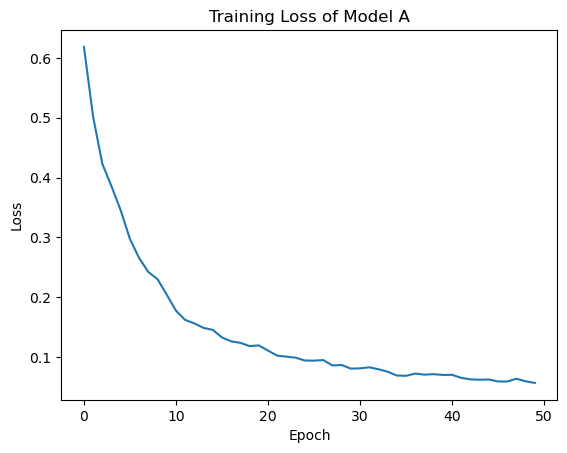

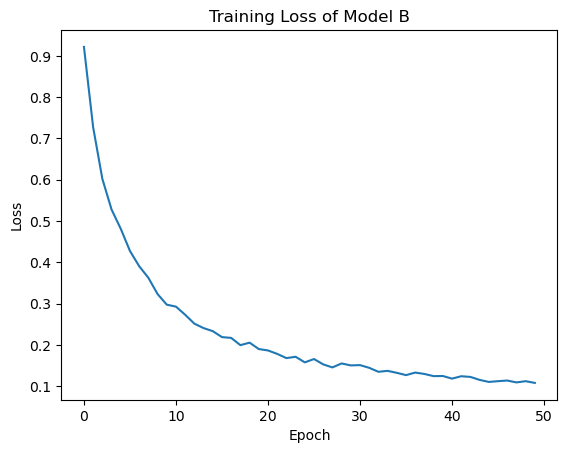

In [6]:
visualizeTrainingLoss(city_a_train_losses, "Training Loss of Model A")
visualizeTrainingLoss(city_b_train_losses, "Training Loss of Model B")

  - *E2* - Testing the models in the dataset. You must implement code routines to test the predictive ability of your models using half of each dataset intended for testing. **The model trained in city A must be tested in city A. The model trained in city B must be tested in city B.** Use the evaluation metrics (accuracy, F1-score, AUC, etc) that are most appropriate for your problem. Plot graphs that illustrate the results obtained for each city (A and B). Plot visual examples of correctly (true positive) and incorrectly (false positive) classified samples. 

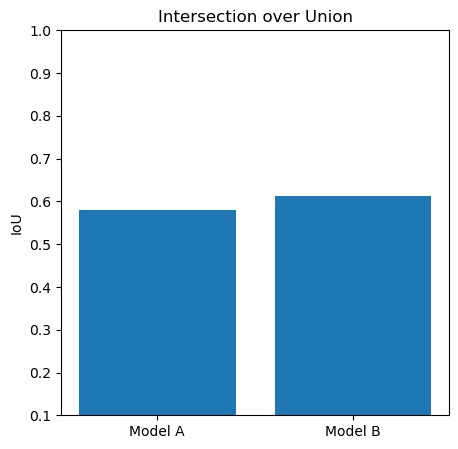

In [7]:
%matplotlib inline 
# get the CustomDataset objects
city_a_test_dataset = getDataset(city_a_test_dir)
city_b_test_dataset = getDataset(city_b_test_dir)

# get dataloaders
city_a_test_dataloader = getDataloader(city_a_test_dataset, batchSize)
city_b_test_dataloader = getDataloader(city_b_test_dataset, batchSize)

# call test function
model_a_avg_loss, model_a_iou = test(model_a, city_a_test_dataloader)
model_b_avg_loss, model_b_iou = test(model_b, city_b_test_dataloader)

# visualize test results
visualizeIoUValues(round(model_a_iou.cpu().item(), 4), round(model_b_iou.cpu().item(), 4))

### Performance of Model 'A' on random image

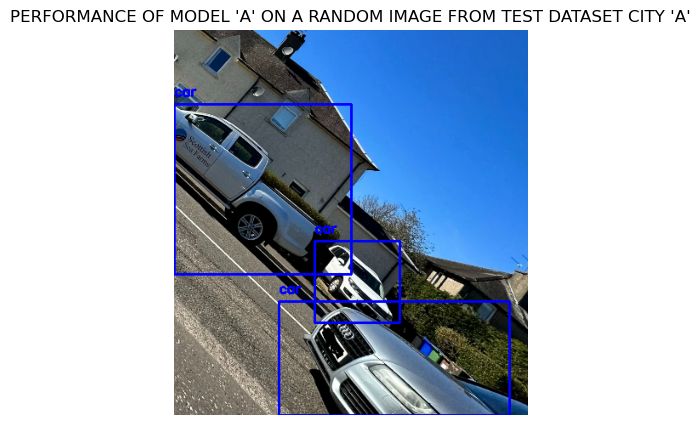

In [8]:
# INFERENCE
# performance on random image
randomInferenceVisualization(True, model_a, city_a_test_dir, 
                             "PERFORMANCE OF MODEL 'A' ON A RANDOM IMAGE FROM TEST DATASET CITY 'A'", 0.9)

### Bad performance example of Model 'A'

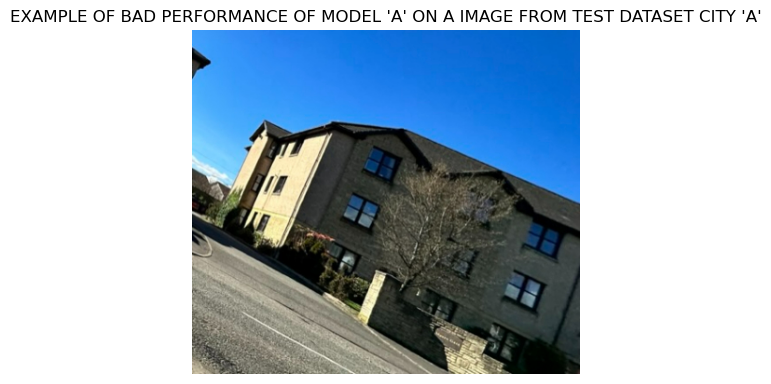

In [9]:
# bad performance example
randomInferenceVisualization(False,
                             model_a, 
                             "/content/dataset/city_a/test/stirling_119.jpg", 
                             "EXAMPLE OF BAD PERFORMANCE OF MODEL 'A' ON A IMAGE FROM TEST DATASET CITY 'A'", 0.9)

### Good performance example of Model 'A'

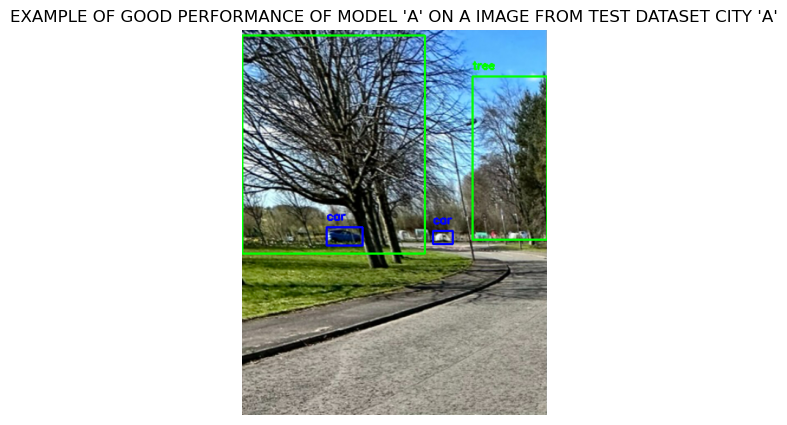

In [10]:
# good performance example
randomInferenceVisualization(False,
                             model_a, 
                             "/content/dataset/city_a/test/stirling_80.jpg", 
                             "EXAMPLE OF GOOD PERFORMANCE OF MODEL 'A' ON A IMAGE FROM TEST DATASET CITY 'A'", 0.9)

### Performance of Model 'B' on random image

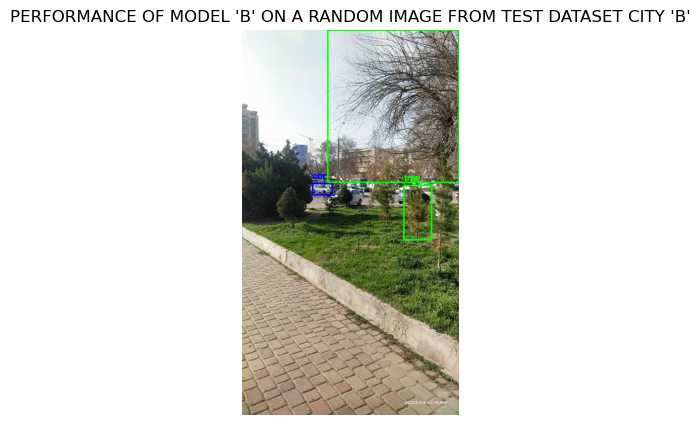

In [11]:
# performance on random image
randomInferenceVisualization(True, model_b, city_b_test_dir, 
                             "PERFORMANCE OF MODEL 'B' ON A RANDOM IMAGE FROM TEST DATASET CITY 'B'", 0.9)

### Bad performance example of Model 'B'

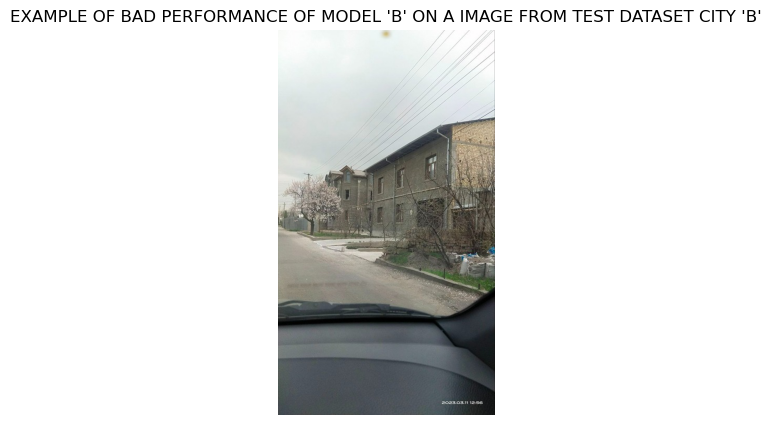

In [12]:
# bad performance example
randomInferenceVisualization(False,
                             model_b, 
                             "/content/dataset/city_b/test/tashkent_83.jpg", 
                             "EXAMPLE OF BAD PERFORMANCE OF MODEL 'B' ON A IMAGE FROM TEST DATASET CITY 'B'", 0.9)

### Good performance example of Model 'B'

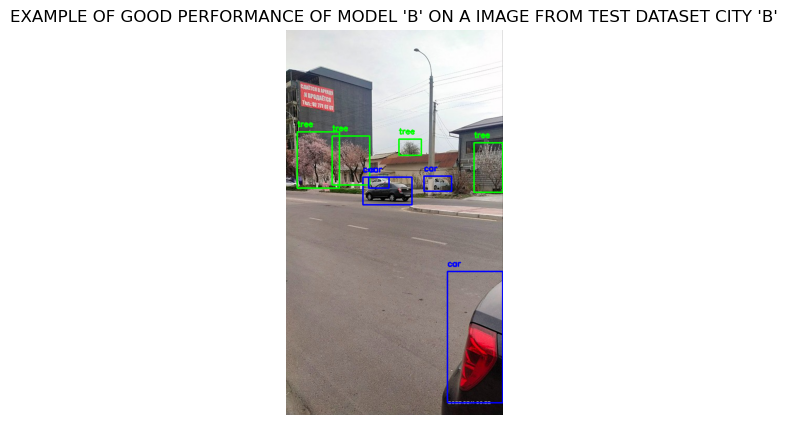

In [13]:
# good performance example
randomInferenceVisualization(False,
                             model_a, 
                             "/content/dataset/city_b/test/tashkent_76.jpg", 
                             "EXAMPLE OF GOOD PERFORMANCE OF MODEL 'B' ON A IMAGE FROM TEST DATASET CITY 'B'", 0.9)

  - *E3* - Testing the models crossing datasets. Here you must do exactly the same as in *E2*, but now training in one city and testing in the other. **The model trained in city A must be tested in city B. The model trained in city B must be tested in city A.** Use the same metrics and plot the same types of graphs so that results are comparable.

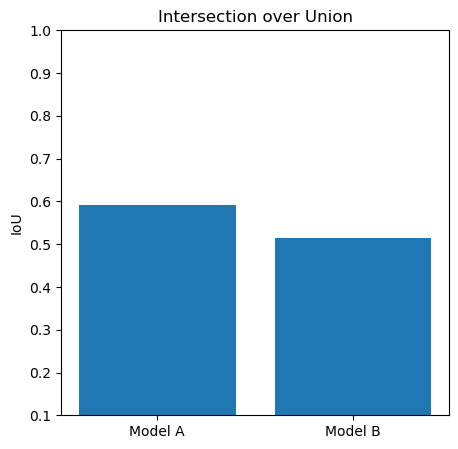

In [14]:
# call test function
model_a_avg_loss, model_a_datab_iou = test(model_a, city_b_test_dataloader)
model_b_avg_loss, model_b_dataa_iou = test(model_b, city_a_test_dataloader)

visualizeIoUValues(round(model_a_datab_iou.cpu().item(), 4), round(model_b_dataa_iou.cpu().item(), 4))

In [15]:
### Performance of Model 'A' on random image

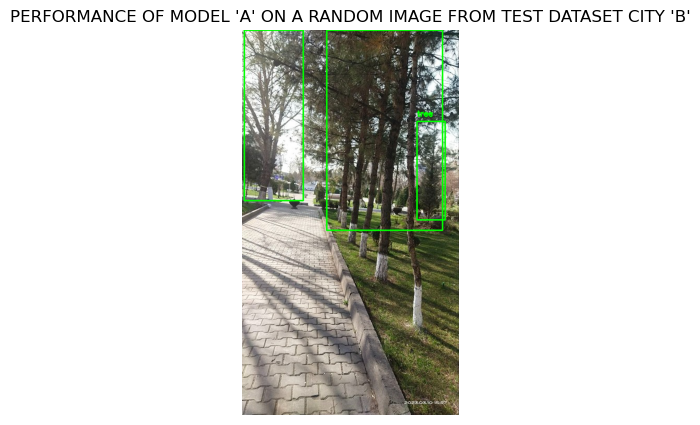

In [16]:
# INFERENCE
# performance on random image
randomInferenceVisualization(True, model_a, city_b_test_dir, 
                             "PERFORMANCE OF MODEL 'A' ON A RANDOM IMAGE FROM TEST DATASET CITY 'B'", 0.9)

In [17]:
### Bad performance example of Model 'A'

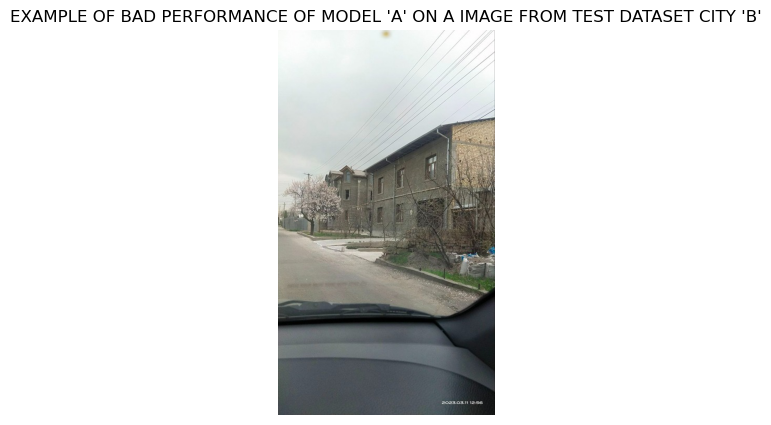

In [18]:
# bad performance example
randomInferenceVisualization(False,
                             model_a, 
                             "/content/dataset/city_b/test/tashkent_83.jpg", 
                             "EXAMPLE OF BAD PERFORMANCE OF MODEL 'A' ON A IMAGE FROM TEST DATASET CITY 'B'", 0.9)

In [19]:
### Good performance example of Model 'A'

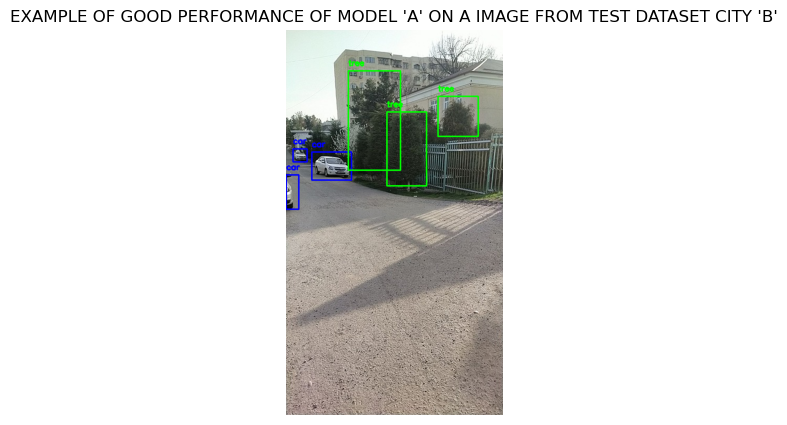

In [20]:
# good performance example
randomInferenceVisualization(False,
                             model_a, 
                             "/content/dataset/city_b/test/tashkent_47.jpg", 
                             "EXAMPLE OF GOOD PERFORMANCE OF MODEL 'A' ON A IMAGE FROM TEST DATASET CITY 'B'", 0.9)

### Performance of Model 'B' on random image

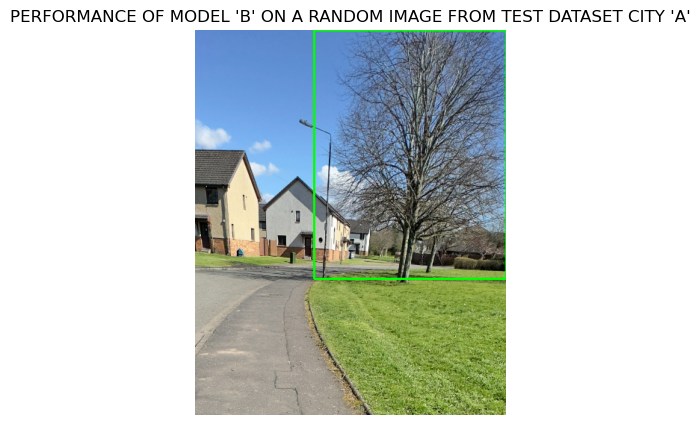

In [21]:
# performance on random image
randomInferenceVisualization(True, model_b, city_a_test_dir, 
                             "PERFORMANCE OF MODEL 'B' ON A RANDOM IMAGE FROM TEST DATASET CITY 'A'", 0.9)

### Bad performance example of Model 'B'

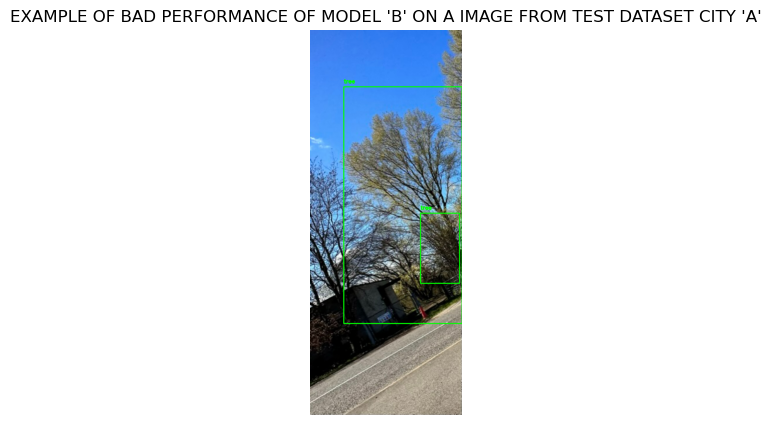

In [22]:
# bad performance example
randomInferenceVisualization(False,
                             model_b, 
                             "/content/dataset/city_a/test/stirling_104.jpg", 
                             "EXAMPLE OF BAD PERFORMANCE OF MODEL 'B' ON A IMAGE FROM TEST DATASET CITY 'A'", 0.9)

### Good performance example of Model 'B'

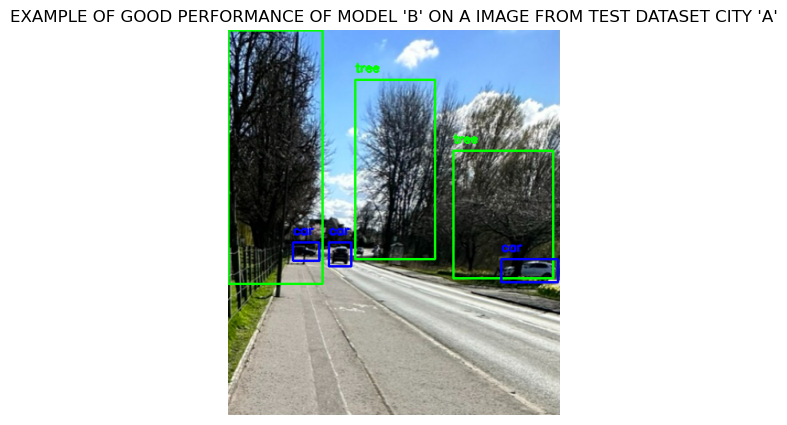

In [23]:
# good performance example
randomInferenceVisualization(False,
                             model_a, 
                             "/content/dataset/city_a/test/stirling_95.jpg", 
                             "EXAMPLE OF GOOD PERFORMANCE OF MODEL 'B' ON A IMAGE FROM TEST DATASET CITY 'A'", 0.9)

---

# 6. **References** 

1.	PyTorch’s fasterrcnn_resnet50_fpn documentation: [Link](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)
2.	bulkresizephotos: [Link](https://bulkresizephotos.com/en?quality=1&type=width&value=416)
3.	makesense.ai: [Link](https://www.makesense.ai/)
4.	Creating custom dataset PyTorch documentation: [Link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
5.	Creating DataLoader PyTorch documentation: [Link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)
6.	C. Versloot, "How to Use PyTorch Loss Functions," GitHub, 2021. [Online]. Available: 
[Link](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-pytorch-loss-functions.md)
7.	J. Brownlee, "Overfitting and Underfitting With Machine Learning Algorithms," Machine Learning Mastery. [Online]. Available: [Link](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/). [Accessed: Apr. 1, 2023].
8.	Stack Overflow, "Calculating percentage of Bounding box overlap, for image detector evaluation": [Link](https://stackoverflow.com/a/65988061/9512000)
9.  "Introduction to Pyplot" Matplotlib: [Link](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)
10. "Reading and Writing XML Files in Python," GeeksforGeeks. [Online]. Available: [Link](https://www.geeksforgeeks.org/reading-and-writing-xml-files-in-python/).
11. S. Chilamkurthy, "Data Loading and Processing Tutorial," PyTorch Tutorials, 2021. [Online]. Available: [Link](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
12. "OpenCV Drawing Functions," OpenCV. [Online]. Available: [Link](https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html)